# 0. Marking and Guidelines
---
***IMPORTANT***

> The **attendance** and **active participation** in the **lab sessions** is **strongly recommended** and will be considered for grading.
>
> Save a copy of this notebook into your Drive before you start
> 
> Please attempt all the **questions** marked for your **group** (Part II ✅ | Part III/MPhil ✅).
> 
> Please, provide your answers in a **new cell below the question cell**. You can make as many new cells as you need.

Please submit a `.zip` file, containing both parts, consisting of:
1. A text file with a **publicly** visible link to your notebooks in GitHub.
2. A **downloaded copy** (`.ipynb`) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report---we will not be re-executing the code you used to produce the answers unless required.


Feel free to attempt more in case you find yourself enjoying the material!
If you have any questions, please ask them to the teaching assistants.
Are you interested in knowing more about federated learning and related topics? Reach out to the teaching assistants for additional resources and ask more about the current research projects.

## Dependencies
---


In [3]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet pandas=="2.1.2"
! pip install --quiet seaborn=="0.13.0"
! pip install --quiet matplotlib tqdm seaborn 
! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
    torch torchvision ray=="2.6.3"
! pip install -U ipywidgets



  Cloning https://github.com/Iacob-Alexandru-Andrei/flower.git (to revision teaching) to /private/var/folders/6j/51pt41xs611cqzmtybytnss40000gn/T/pip-req-build-x27z7bzw
  Running command git clone --filter=blob:none --quiet https://github.com/Iacob-Alexandru-Andrei/flower.git /private/var/folders/6j/51pt41xs611cqzmtybytnss40000gn/T/pip-req-build-x27z7bzw
  Running command git checkout -b teaching --track origin/teaching
  Switched to a new branch 'teaching'
  Branch 'teaching' set up to track remote branch 'teaching' from 'origin'.
  Resolved https://github.com/Iacob-Alexandru-Andrei/flower.git to commit 1c4fcc1d4a6e8022ddf6f94ebedef1b8e70e0fc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4

### Imports.


In [333]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client


from common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator, 
    # get_network_generator_mlp as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

In [334]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

## 5. Building a Flower FL client.
---

Our first client abstraction shall be as simple as possible and will require adjustment to match the structure that the flower framework expects. However, it shall be conceptually identical and require only light API changes.

Moving from centralised ML to server-client FL requires us to provide a means of communication between the respective server and clients. The Flower Framework is ML-framework agnostic and allows various means of transmitting model parameters in the federated network. Since you may have limited resources in these labs, we will only tangentially follow the Flower framework while keeping the computational requirements to a minimum.

The simplest and most common encoding for models is the mere transmission of model parameters as NumPy arrays instead of the stateful PyTorch models. The following functions allow for seamless conversions between the two.

In [335]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Put a set of parameters into the model object.

    Parameters
    ----------
        net (Module): model object.
        parameters (NDArrays): set of parameters to put into the model.

    Returns
    -------
        Module: updated model object.
    """
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights, strict=False)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Get the current model parameters as NDArrays.

    Parameters
    ----------
        net (Module): current model object.

    Returns
    -------
        NDArrays: set of parameters from the current model.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

With them in place, making the client abstraction compatible with Flower requires only a bit of boilerplate such as allowing NumPy arrays to be received and sent instead of PyTorch models. To achieve this, we provide a model generator capable of creating a network and using the received parameters.

To keep client objects light in the memory when not used by the Flower FL simulator, the model generator is only called as needed for either `fit` or `evaluate`.

In [336]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters
        ----------
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network.

        Parameters
        ----------
            parameters (NDArrays): set of weights to be loaded.

        Returns
        -------
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Parameters
        ----------
            config (dict[int, Scalar]): dictionary containing configuration info.

        Returns
        -------
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
                dataset and other metrics
        """
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters.

        Parameters
        ----------
            config (dict[str, Scalar]): dictionary containing dataloader and dataset
                parameters
            mode (str): Load the training or testing set for the client

        Returns
        -------
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client.

        Parameters
        ----------
            config (dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns
        -------
            dict[str, Scalar]: Returned properties.
        """
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size.

        Returns
        -------
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size.

        Returns
        -------
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


def fit_client_seeded(
    client: FlowerRayClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

The underlying FL simulator used by Flower is based on [Ray](https://www.ray.io/). It expects each client only to require a client ID for instantiation. Therefore, using the following generator function, we can determine the specific network used for FL together with the FEMNIST partition to which the `cid` refers.

While we will not use `Ray` in this lab due to its heavyweight nature, we will keep all code API compatible with the default flower framework.

In [337]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to be of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

To ensure the Flower client behaves the same as our simple demo client, a simple test using the centralised partition we defined earlier should suffice.

In [338]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-02-10 14:08:10,132 | 2290543087.py:21 | cid: 0


In [339]:
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)
log(INFO, "Number of examples = %s", num_examples)

INFO flwr 2025-02-10 14:08:17,084 | 2385785060.py:20 | Train Metrics = {'train_loss': 0.11729214809834958}
INFO flwr 2025-02-10 14:08:17,085 | 2385785060.py:21 | Number of examples = 20189


In [340]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

  4%|▍         | 100/2329 [00:02<00:45, 48.87it/s]
INFO flwr 2025-02-10 14:08:21,635 | 592755603.py:5 | Loss = 370.11393570899963; Test Metrics = {'local_accuracy': 0.059375}


## 6. FL with natural partitions
---

Given its naturally-partitioned nature, we can easily construct a realistic FL experiment by mapping clients one-to-one with the writers of the original symbols.

To pursue this aim, we shall use the “naturally federated” partition instead of the "centralised” one. We are then using the entire `train.csv` and `test.csv` contained in the subfolders of `client_data_mappings/fed_natural`. Each subfolder is named after the clients' ID in the dataset, i.e., from `0` to `3229`.

To guarantee that each client has sufficient training data to participate meaningfully, a common practice is to set a lower bound on the number of samples a selected client is allowed to have. Generally, this threshold should be equivalent to at least one batch. We will now implement a function to sample clients from the federation that satisfies the abovementioned filter in the train set.

In [341]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns
    -------
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [342]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-10 14:08:27,065 | 2290543087.py:21 | cid: 2530
INFO flwr 2025-02-10 14:08:27,067 | 2290543087.py:21 | cid: 2184
INFO flwr 2025-02-10 14:08:27,068 | 2290543087.py:21 | cid: 2907
INFO flwr 2025-02-10 14:08:27,068 | 2290543087.py:21 | cid: 1498
INFO flwr 2025-02-10 14:08:27,069 | 2290543087.py:21 | cid: 2338
INFO flwr 2025-02-10 14:08:27,070 | 2290543087.py:21 | cid: 2399
INFO flwr 2025-02-10 14:08:27,071 | 2290543087.py:21 | cid: 2997
INFO flwr 2025-02-10 14:08:27,071 | 2290543087.py:21 | cid: 678
INFO flwr 2025-02-10 14:08:27,072 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-10 14:08:27,074 | 2290543087.py:21 | cid: 1363
INFO flwr 2025-02-10 14:08:27,074 | 2290543087.py:21 | cid: 1571
INFO flwr 2025-02-10 14:08:27,075 | 2290543087.py:21 | cid: 2600
INFO flwr 2025-02-10 14:08:27,077 | 2290543087.py:21 | cid: 1473
INFO flwr 2025-02-10 14:08:27,078 | 2290543087.py:21 | cid: 1260
INFO flwr 2025-02-10 14:08:27,078 | 2290543087.py:21 | cid: 1603
INFO flwr 2025-02-10 14:08

Now, to test that the newly partitioned clients can be trained.

In [294]:
one_epoch_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

five_epoch_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [295]:
num_clients = 4
clients = random.sample(list(range(total_clients)), num_clients)

In [296]:
trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, one_epoch_config
    )
    for cid in clients
]

INFO flwr 2025-02-07 22:41:48,327 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-07 22:41:48,488 | 2290543087.py:21 | cid: 51
INFO flwr 2025-02-07 22:41:48,821 | 2290543087.py:21 | cid: 1668
INFO flwr 2025-02-07 22:41:48,909 | 2290543087.py:21 | cid: 1498


In [297]:
trained_model_parameters = [model for model, *rest in trained_models]
trained_model_metrics = [rest for _, *rest in trained_models]
log(INFO, "Metrics from trained models are: %s", trained_model_metrics)

INFO flwr 2025-02-07 22:41:51,684 | 756348695.py:3 | Metrics from trained models are: [[4, {'train_loss': 0.7092106826603413}], [11, {'train_loss': 0.27686170691793616}], [3, {'train_loss': 0.6690514832735062}], [4, {'train_loss': 0.5892780125141144}]]


---

**Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

If we index the weights of an ML model consecutively, with the assumed architecture being the same, we can visualize it as a single flattened 1-D vector. One, highly imperfect, metric for determining how similar two ML models are is cosine similarity. We can use this metric to compare the models our clients produce are.

1. Write functions to:
    - Flatten the `NDArrays` objects into a single 1-D vector.
    - Compute the cosine similarity of two 1-D vectors based on their inner product and norms.
2. Compute a similarity matrix between all client models and plot it.
3. What happens to the similarity matrix if you increase the number of local epochs that clients train for to 5 from 1? Why do you think that is?
>You may want to save the parameters calculated here separately from the deault ones as both sets will be needed in future questions.

---


--- 
**Question 5 Answers:**


Part 1:

In [214]:
def flatten_ndarray(ndarray: list)-> np.array:
    """
        Flatten a list of numpy arrays into a single numpy array.

        Parameters
        ----------
            ndarray (list): list of numpy arrays.

        Returns
        -------
            np.array: flattened numpy array.
    """
    
    flattened_ndarray = np.array([])
    for array in ndarray:
        falttened_array = array.ravel()
        flattened_ndarray = np.concatenate((flattened_ndarray, falttened_array))

    return flattened_ndarray
    

def cosine_similarity(model_vector_1: np.array, model_vector_2: np.array)-> float:
    """
        Calculate the cosine similarity between two model vectors.

        Parameters
        ----------
            model_vector_1 (np.array): first model vector.
            model_vector_2 (np.array): second model vector.

        Returns
        -------
            float: cosine similarity between the two model vectors.
    """
    dot_product = np.dot(model_vector_1, model_vector_2)
    norm_1 = np.linalg.norm(model_vector_1)
    norm_2 = np.linalg.norm(model_vector_2)
    cosine_similarity = dot_product / (norm_1 * norm_2)
    return cosine_similarity




Part 2:

In [215]:
def calculate_client_model_similarities(model_parameters: list)-> np.array:
    """
        Calculate the cosine similarity between all the client models.

        Parameters
        ----------
            model_parameters (list): list of trained model parameters.

        Returns
        -------
            np.array: matrix of cosine similarities between all the client models.
    """

    flattened_models = [flatten_ndarray(model) for model in model_parameters]
    cosine_similarities = np.zeros((len(flattened_models), len(flattened_models)))

    for i in range(len(flattened_models)):
        for j in range(len(flattened_models)):
            cosine_similarities[i][j] = cosine_similarity(flattened_models[i], flattened_models[j])

    return cosine_similarities

In [305]:
import matplotlib.pyplot as plt
def plot_cosine_similiarities_between_models(cosine_similarities: np.array, number_of_epochs:int, is_average_last: bool = False):
    """
        Plot the cosine similarity matrix between the client models.

        Parameters
        ----------
            cosine_similarities (np.array): matrix of cosine similarities between all the client models.
            number_of_epochs (int): number of epochs for which the models were trained.
            is_average_last (bool): whether the last client model is the average model.

    """
    number_of_clients = cosine_similarities.shape[0]
    client_labels = [f"Client {i+1}" for i in range(number_of_clients)]

    if is_average_last:
        client_labels = [f"Client {i+1}" for i in range(number_of_clients-1)]
        client_labels.append("Averaged Model")
    

    sns.heatmap(
        data=cosine_similarities,
        linewidths=1,
        annot=True,
        cmap="coolwarm",
        xticklabels=client_labels,
        yticklabels=client_labels
    )
    
    plt.title(f"Cosine Similarity Matrix Between Client Models for {number_of_epochs} epochs")
    plt.xlabel("Client Model Index")
    plt.ylabel("Client Model Index")
    
    plt.xticks(rotation=45)
    
    plt.show()


In [217]:
one_epoch_trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, one_epoch_config
    )
    for cid in clients
]

one_epoch_trained_model_parameters = [model for model, *rest in one_epoch_trained_models]
one_epoch_trained_model_metrics = [rest for _, *rest in one_epoch_trained_models]



INFO flwr 2025-02-07 17:06:37,093 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-07 17:06:37,153 | 2290543087.py:21 | cid: 51
INFO flwr 2025-02-07 17:06:37,297 | 2290543087.py:21 | cid: 1668
INFO flwr 2025-02-07 17:06:37,337 | 2290543087.py:21 | cid: 1498


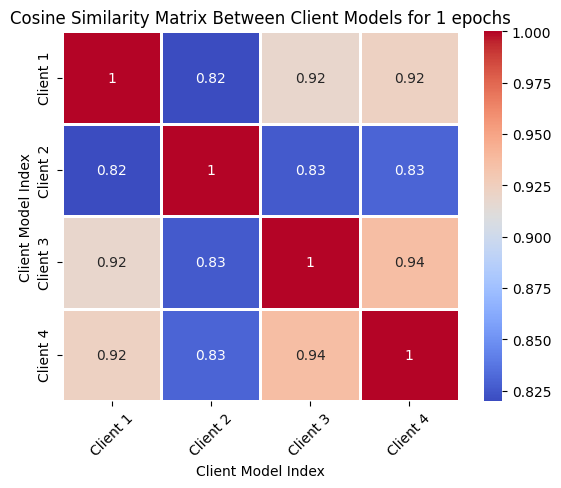

In [306]:
plot_cosine_similiarities_between_models(calculate_client_model_similarities(one_epoch_trained_model_parameters), 1)

Part 3:

In [219]:
five_epoch_trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, five_epoch_config
    )
    for cid in clients
]

five_epoch_trained_model_parameters = [model for model, *rest in five_epoch_trained_models]
five_epoch_trained_model_metrics = [rest for _, *rest in five_epoch_trained_models]


INFO flwr 2025-02-07 17:06:42,164 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-07 17:06:42,366 | 2290543087.py:21 | cid: 51
INFO flwr 2025-02-07 17:06:43,095 | 2290543087.py:21 | cid: 1668
INFO flwr 2025-02-07 17:06:43,284 | 2290543087.py:21 | cid: 1498


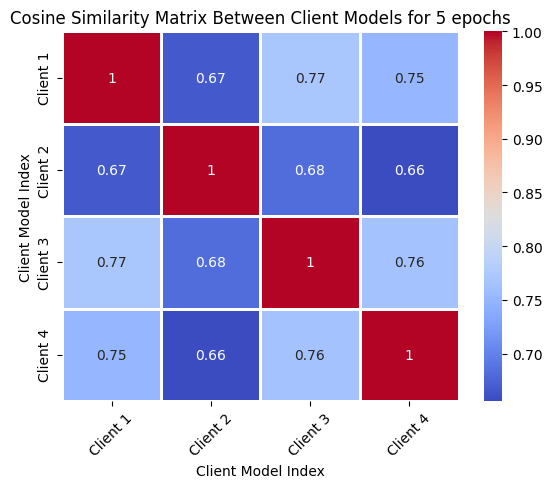

In [307]:
plot_cosine_similiarities_between_models(calculate_client_model_similarities(five_epoch_trained_model_parameters),5)

**Written Answer:** The similarity between the models start to decrease as we increase the number of epochs that each client executes over their local dataset from 1 to 5. This decrease in similarity is caused by the fact that the models start to learn more specific features of their local dataset over multiple epochs, which makes them more different from each other. 

---
**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

One reason that cosine similarity is an imperfect metric is because it considers weights from different layers to be equally important to the model in terms of its behavior and performance. We can thus create a slightly more detailed picture by tracking the cosine similarity across layers.

1. Create a function which computes the pairwise cosine similarity between flattened model layers across clients, i.e. the cosine similarity between the flattened $l_i$ in `client_x` and the flattened $l_i$ in `client_y`.
2. Plot the similarity of the models at each layer between the most similar client pair and the most disimilar client pair (as determined by the multi-epoch experiment) using the **one-epoch models**, how do the curves you observe relate to the general cosine similarity you computed for the flattened models.
3. What happens to the curves if you increase the number of local epochs to 5? How does this behavior relate to what you observed in the previous exercise ?
4. **Optional**: Do you think there is any connection to the underlying architecture? Why? Repeat the above experiments using an MLP such as the one provided by the  `get_network_generator_mlp` in `client_utils` and compare results against the CNN.

---

**Question 6 Answers:**

Part 1:

In [221]:
def flatten_model_layers(ndarray: list)-> list:
    """
        Flatten a list of numpy arrays

        Parameters
        ----------
            ndarray (list): list of numpy arrays.

        Returns
        -------
            list: list of flattened numpy arrays.
    """
    flattened_layers = []
    for array in ndarray:
        flattened_layers.append(array.ravel())

    return flattened_layers

def pairwise_cosine_similarity(model_layers_1: list, model_layers_2: list)-> list:
    """
        Calculate the cosine similarity between the flattened layers of two models.

        Parameters
        ----------
            model_layers_1 (list): list of flattened numpy arrays representing the layers of the first model.
            model_layers_2 (list): list of flattened numpy arrays representing the layers of the second model.

        Returns
        -------
            list: list of cosine similarities between the layers of the two models.
    """
    layer_cosine_similarities = []
    for i in range(len(model_layers_1)):
        layer_cosine_similarities.append(cosine_similarity(model_layers_1[i], model_layers_2[i]))

    return layer_cosine_similarities


def calculate_layer_similarities(trained_model_1:list, trained_model_2: list)-> list:
    """
        Flattend the layers of the two models and calculate the cosine similarity between them.

        Parameters
        ----------
            trained_model_1 (list): list of trained model parameters for the first model.
            trained_model_2 (list): list of trained model parameters for the second model.

        Returns
        -------
            list: list of cosine similarities between the layers of the two models.

    """

    flattened_model_1 = flatten_model_layers(trained_model_1)
    flattened_model_2 = flatten_model_layers(trained_model_2)    

    layer_cosine_similarities = pairwise_cosine_similarity(flattened_model_1, flattened_model_2)

    return layer_cosine_similarities

def find_most_similar_client_pair(cosine_similarities: np.array) -> tuple:
    """
        Find the pair of clients with the highest cosine similarity.

        Parameters
        ----------
            cosine_similarities (np.array): matrix of cosine similarities between all the client models.

        Returns
        -------
            tuple: pair of clients with the highest cosine similarity.
    """

    max_similarity =0
    most_similar_pair = (0, 0)
    for i in range(cosine_similarities.shape[0]):
        for j in range(cosine_similarities.shape[1]):
            if i != j and cosine_similarities[i][j] > max_similarity:
                max_similarity = cosine_similarities[i][j]
                most_similar_pair = (i, j)
    return most_similar_pair


def find_most_dissimilar_pair(cosine_similarities: np.array) -> tuple:
    """
        Find the pair of clients with the lowest cosine similarity.

        Parameters
        ----------
            cosine_similarities (np.array): matrix of cosine similarities between all the client models.

        Returns
        -------
            tuple: pair of clients with the lowest cosine similarity.
    """
    min_similarity = 1
    most_dissimilar_pair = (0, 0)
    for i in range(cosine_similarities.shape[0]):
        for j in range(cosine_similarities.shape[1]):
            if i != j and cosine_similarities[i][j] < min_similarity:
                min_similarity = cosine_similarities[i][j]
                most_dissimilar_pair = (i, j)

    return most_dissimilar_pair
  


Part 2:

In [276]:
def plot_layer_similarities(most_similar_layers: list, most_dissimilar_layers:list, similar_pair: tuple, dissimilar_pair: tuple, epochs: int, is_average_model:bool =False):
    """
        Plot the layerwise cosine similarity between the most similar and most dissimilar client pairs.

        Parameters
        ----------
            most_similar_layers (list): list of cosine similarities between the layers of the most similar client pair.
            most_dissimilar_layers (list): list of cosine similarities between the layers of the most dissimilar client pair.
            similar_pair (tuple): pair of clients with the highest cosine similarity.
            dissimilar_pair (tuple): pair of clients with the lowest cosine similarity.
            epochs (int): number of epochs for which the models were trained.
            is_average_model (bool): whether the last client index per pair is the average model
        """
    

    
    layers = np.arange(1, len(most_similar_layers)+1)

    if is_average_model:
        plt.plot(layers, most_similar_layers, marker='o',
         label=f'Most Similar Pair: Client {similar_pair[0] +1} and Avereaged Model')
        plt.plot(layers, most_dissimilar_layers, marker='o',
                label=f'Most Dissimilar Pair: Client {dissimilar_pair[0] +1} and Average Model')
    else:
        plt.plot(layers, most_similar_layers, marker='o',
            label=f'Most Similar Pair: Client {similar_pair[0] +1 } and Client {similar_pair[1] +1}')
        plt.plot(layers, most_dissimilar_layers, marker='o',
                label=f'Most Dissimilar Pair: Client {dissimilar_pair[0] +1} and Client {dissimilar_pair[1]+1}')

    plt.xlabel("Layer Index")
    plt.ylabel("Cosine Similarity")
    plt.title(f"Layerwise Cosine Similarity between Client Models for {epochs} epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    

In [223]:
def layer_similarities(model_parameters: list, five_epoch_parameters: list, epochs: int):
    """
        Calculate the cosine similarity between the layers of the client models and plot the layerwise cosine similarity between the most similar and most dissimilar client pairs.

        Parameters
        ----------
            model_parameters (list): list of trained model parameters for the model to be evaluated.
            five_epoch_parameters (list): list of trained model parameters for the five epoch model for pair finding.
            epochs (int): number of epochs for which the models were trained.

    """
    
    similarities = calculate_client_model_similarities(five_epoch_parameters)
    most_similar_pair = find_most_similar_client_pair(similarities)
    most_dissimilar_pair = find_most_dissimilar_pair(similarities)
    most_similar_layers = calculate_layer_similarities(model_parameters[most_similar_pair[0]], model_parameters[most_similar_pair[1]])
    most_dissimilar_layers = calculate_layer_similarities(model_parameters[most_dissimilar_pair[0]], model_parameters[most_dissimilar_pair[1]])
    plot_layer_similarities(most_similar_layers, most_dissimilar_layers, most_similar_pair, most_dissimilar_pair,epochs)

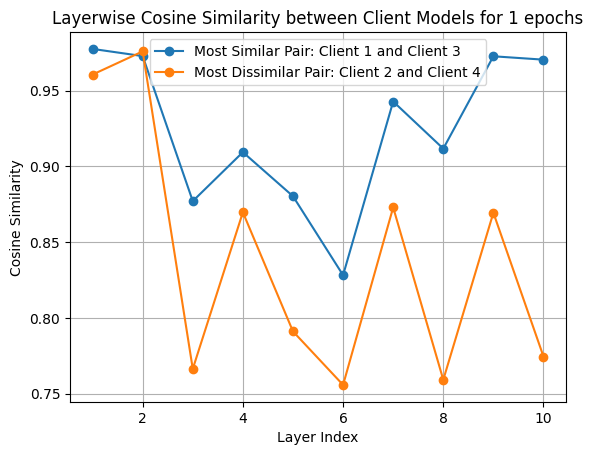

In [224]:
layer_similarities(one_epoch_trained_model_parameters, five_epoch_trained_model_parameters, 1)

**Written answer:** From the graph we can see that the cosine similarity is not uniform between layers of the models and that the single cosine similarity score provides an average of the similarity between the models' layers. We can see that some of the similarity scores between layers are well below or above the one indicated by the single cosine similar, Another interesting observation is that the similarity of shallower layers is higher than the deeper layers in both pairs. This is because the shallower layers learn more general features of the dataset, which are common across all clients, while the deeper layers learn more specific features of the dataset, which are unique to each client. 

Part 3:

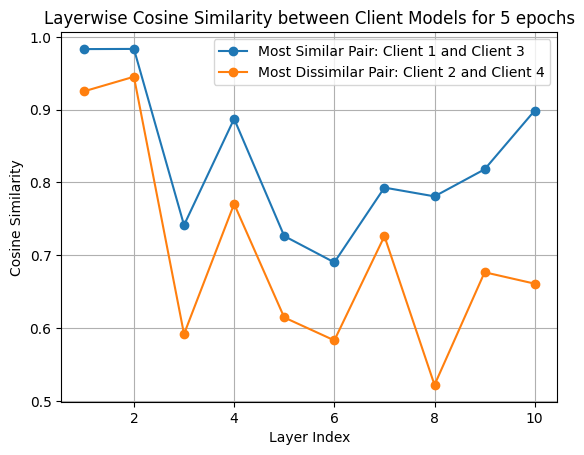

In [225]:
layer_similarities(five_epoch_trained_model_parameters,five_epoch_trained_model_parameters, 5)

**Written Answer:** When the number of epochs is increased to 5, the cosine similarity between the models' layers decrease in case of both pairs as was shown earlier in the single cosine score exercise as well. However, as shown earlier the similarity between the layers remains varied hence a single similarity score might not be representative. Furthermore, as mentioned earlier the initial/ shallow layers of the models maintain a relatively high similarity compared to the deeper layers in case of both pairs. 

Part 4 (Optional):

In [298]:
mlp_one_epoch_trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, one_epoch_config
    )
    for cid in clients
]

mlp_one_epoch_trained_model_parameters = [model for model, *rest in mlp_one_epoch_trained_models]
mlp_one_epoch_trained_model_metrics = [rest for _, *rest in mlp_one_epoch_trained_models]

INFO flwr 2025-02-07 22:42:09,696 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-07 22:42:09,825 | 2290543087.py:21 | cid: 51
INFO flwr 2025-02-07 22:42:10,098 | 2290543087.py:21 | cid: 1668
INFO flwr 2025-02-07 22:42:10,192 | 2290543087.py:21 | cid: 1498


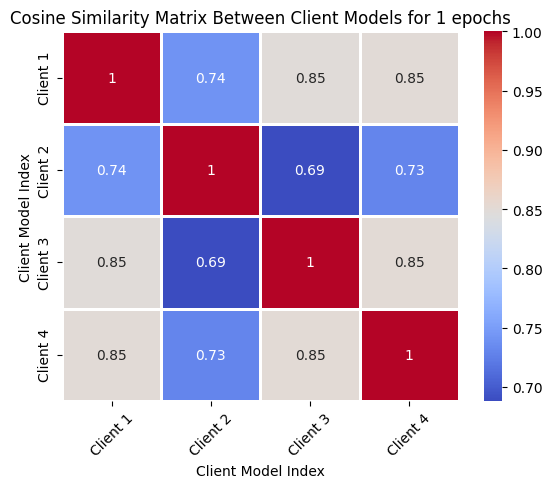

In [309]:
plot_cosine_similiarities_between_models(calculate_client_model_similarities(mlp_one_epoch_trained_model_parameters),1)

In [300]:
mlp_five_epoch_trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, five_epoch_config
    )
    for cid in clients
]

mlp_five_epoch_trained_model_parameters = [model for model, *rest in mlp_five_epoch_trained_models]
mlp_five_epoch_trained_model_metrics = [rest for _, *rest in mlp_five_epoch_trained_models]


INFO flwr 2025-02-07 22:42:24,343 | 2290543087.py:21 | cid: 3175
INFO flwr 2025-02-07 22:42:24,648 | 2290543087.py:21 | cid: 51
INFO flwr 2025-02-07 22:42:25,550 | 2290543087.py:21 | cid: 1668
INFO flwr 2025-02-07 22:42:25,766 | 2290543087.py:21 | cid: 1498


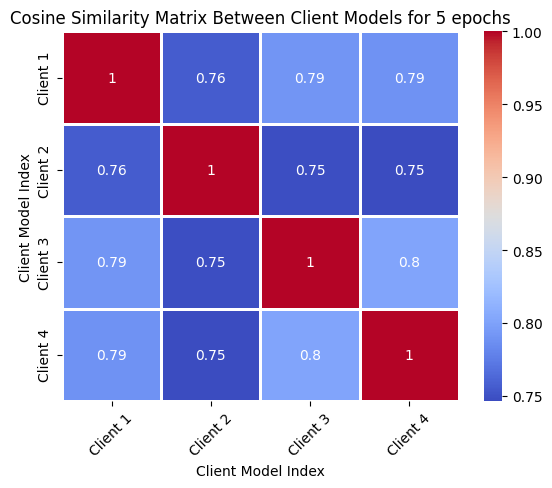

In [310]:
plot_cosine_similiarities_between_models(calculate_client_model_similarities(mlp_five_epoch_trained_model_parameters),5)

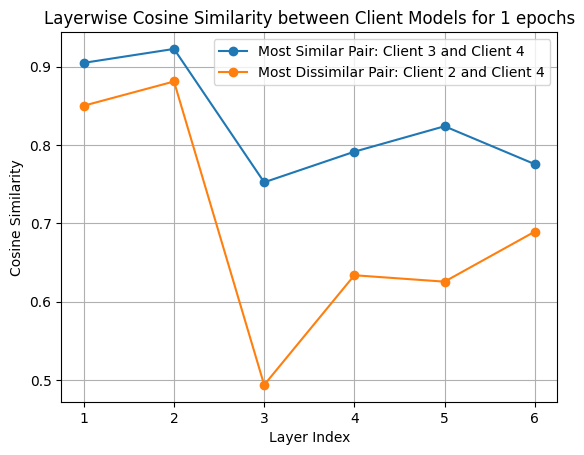

In [302]:
layer_similarities(mlp_one_epoch_trained_model_parameters, mlp_five_epoch_trained_model_parameters, 1)

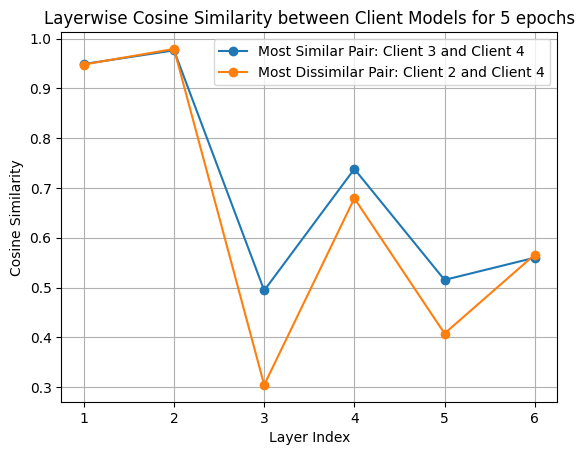

In [303]:
layer_similarities(mlp_five_epoch_trained_model_parameters,mlp_five_epoch_trained_model_parameters, 5)

**Written Answer:**

From the cosine similarity matrices we can see that similarly to the CNN models, the MLP models also show a decrease in similarity between as the number of epochs increases. The similar tendencies can be said for the layer-wise cosine similarity graphs as well. The MLP models also show a higher similarity in the initial layers compared to the deeper layers. The graphs also show that the layer-wise similarity between both the most similar and dissimilar models decline as the number of epochs increased to 5 form 1. Therefore, we can sat that the client model similarity behaviour is independent of the model architecture.

---

## 7. Federated training with Flower
---

The two basic blocks of synchronous server-client FL systems are:
- A client with some local training method and data---i.e., SGD. This is what we have built thus far.
- A server which coordinates training sends the federated model to clients at the start of each round and aggregates model updates at the end of each round.


![picture](https://drive.google.com/uc?id=1Db_Uys2QPFHW6cMranZ_QXo2vC0A_C-N)

While the variety of client local training methods is as wide as ML, server training varies depending on which **aggregation algorithm** combines the model updates and forms the new federated model. Flower refers to the component that controls the aggregation and train/test configuration as a **strategy**. For our labs, strategy and aggregation algorithms will be used interchangeably.

The strategy we shall use is [FedAvg](https://arxiv.org/abs/1602.05629):

$G^{r+1} = G^{r} + \eta \left( \sum_{k=1}^{m} p_k G^r_k \right)$,

where $G^{r+1}$ is the model for the next round, which is formed by applying a model update to the current round model $G^{r}$ weighted by the aggregation learning rate $\eta$. The model update is constructed by a sum of client models $G^{r}_k$ where each client model is weighted by $p_k$. The weight factor is usually set to $p_k = \tfrac{n_k}{N}$---the number of training examples held by said client divided by the example count of each client in the round $N = \sum_{k=1}^{m} n_k$.



---

**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

Averaging models is meant to provide us with a reasonable compromise between the desired models of all clients involved. Given what you already know about the similarity of client models, we can test if this is true.
1. Write a function to compute the weighted average of two `NDArrays` objects while preserving the layer-structure. Use the FedAvg equation above with $p_k = \tfrac{n_k}{N}$.
2. Compute the average model of the client models above, both the one-epoch and multi-epoch ones.
3. Add the averaged models to the cosine-similarity matrices built above, how does it relate to the client models?

---


**Question 7 Answers:**

Part 1 and 2:

In [304]:
def aggregate_samples(model_metrics: list)-> int:
    """
        Aggregate the number of samples across all the clients.

        Parameters
        ----------
            model_metrics (list): list of metrics from the clients.

        Returns
        -------
            int: total number of samples across all the clients.
    """
    total_samples = 0
    for num_examples, _ in model_metrics:
        total_samples += num_examples

    return total_samples


def calculate_average_of_two_ndarrays(model_1: list, model_2: list, model_1_weight:float, model_2_weight: float)-> list:
    """
        Calculate the weighted average of two numpy arrays.

        Parameters
        ----------
            model_1 (list): first numpy array.
            model_2 (list): second numpy array.
            model_1_weight (float): weight for the first numpy array.
            model_2_weight (float): weight for the second numpy array.

        Returns
        -------
            list: weighted average of the two numpy arrays.
    """

    new_model = []
    for i in range(len(model_1)):
        weighted_model_1_layer = model_1_weight * model_1[i]
        weighted_model_2_layer = model_2_weight * model_2[i]
        new_model.append(np.add(weighted_model_1_layer, weighted_model_2_layer))

    return new_model


def average_models(model_parameters: list, model_metrics: list)-> list:
    """
        Calculate the weighted average of the client models.

        Parameters
        ----------
            model_parameters (list): list of trained model parameters for the clients.
            model_metrics (list): list of metrics from the clients.

        Returns
        -------
            list: weighted average of the client models.
    """

    total_samples = aggregate_samples(model_metrics)
    model_weights = [num_examples/total_samples for num_examples, _ in model_metrics]
    averaged_model = calculate_average_of_two_ndarrays(model_parameters[0], model_parameters[1], model_weights[0], model_weights[1])
    for i in range(2, len(model_parameters)):
        averaged_model = calculate_average_of_two_ndarrays(averaged_model, model_parameters[i], 1, model_weights[i])
        

    return averaged_model

Part 3:

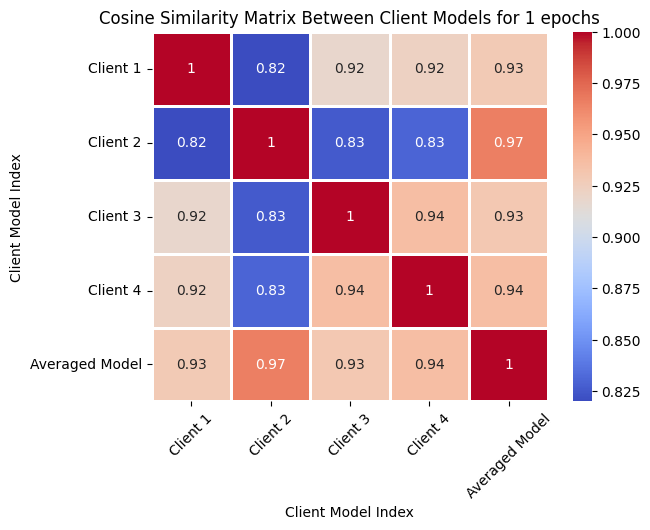

In [311]:
one_epoch_averaged_model = average_models(one_epoch_trained_model_parameters, one_epoch_trained_model_metrics)
one_epoch_average_model_list = one_epoch_trained_model_parameters + [one_epoch_averaged_model]
plot_cosine_similiarities_between_models(calculate_client_model_similarities(one_epoch_average_model_list), 1, is_average_last=True)

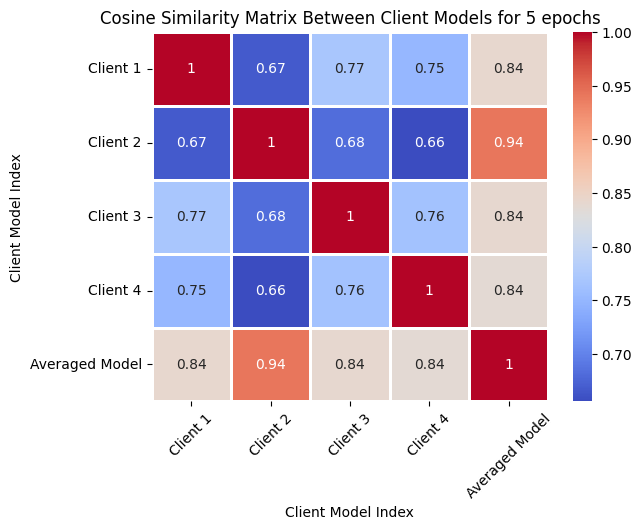

In [312]:
five_epoch_averaged_model = average_models(five_epoch_trained_model_parameters, five_epoch_trained_model_metrics)
five_epoch_average_model_list = five_epoch_trained_model_parameters + [five_epoch_averaged_model]
plot_cosine_similiarities_between_models(calculate_client_model_similarities(five_epoch_average_model_list), 5, is_average_last=True)

**Written Answer:**  In the first epoch, the averaged model has a relatively high similarity score to the models of the clients proportional to their respective weight scores, making it most similar to Client 2 that had 50% of the training examples. Furthermore, the initial high cosine similarity can be also explained by the low epoch number as the models had not started diverging (that much) yet. As the number of epochs were increased to 5 the averaged model started to diverge more to the direction of Client 2 (with the most weight) maintaining a larger similarity to it compared to the others where the similarity decreased.

---
**Question 8 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)


1. Repeat the procedure above but for layer-wise cosine similarity and plot the cosine similarity of the two clients client most similar and most disimillar to the averaged model (as determined by the five-epoch condition) using the one-epoch models.
2. How does the relationship change for the higher-epoch condition?

---

**Question 8 Answers:**

Part 1:

In [315]:
def find_most_similar_client_to_avg_model(cosine_similarities: np.array) -> int:
    """
        Find the client most similar to the average model.

        Parameters
        ----------
            cosine_similarities (np.array): matrix of cosine similarities between all the client models and the average model.

        Returns
        -------
            int: index of the most similar client to the average model.
    """

    max_similarity = 0
    most_similar_index = 0
    j = cosine_similarities.shape[0]-1
    for i in range(cosine_similarities.shape[0]):
        if i != j and cosine_similarities[j][i] > max_similarity:
            max_similarity = cosine_similarities[i][j]
            most_similar_index = i

    return most_similar_index


def find_most_dissimilar_client_to_avg_model(cosine_similarities: np.array) -> int:
    """
        Find the client most dissimilar to the average model.

        Parameters
        ----------
            cosine_similarities (np.array): matrix of cosine similarities between all the client models and the average model.

        Returns
        -------
            int: index of the most dissimilar client to the average model.
    """
    min_similarity = 1
    most_dissimilar_index = 0
    j = cosine_similarities.shape[0]-1
    for i in range(cosine_similarities.shape[0]):
        if i != j and cosine_similarities[j][i] < min_similarity:
            min_similarity = cosine_similarities[i][j]
            most_dissimilar_index = i
    
    return most_dissimilar_index


def averaged_layer_similarities(model_parameters: list, five_epoch_model_parameters:list, epochs: int):
    """
        Calculate the cosine similarity between the layers of the client models and the average model and plot the layerwise cosine similarity between the most similar and most dissimilar client pairs.

        Parameters
        ----------
            model_parameters (list): list of trained model parameters for the model to be evaluated.
            five_epoch_model_parameters (list): list of trained model parameters for the five epoch model for pair finding.
            epochs (int): number of epochs for which the models were trained.

    """
    similarities = calculate_client_model_similarities(five_epoch_model_parameters)
    most_similar_index = find_most_similar_client_to_avg_model(similarities)
    most_dissimilar_index = find_most_dissimilar_client_to_avg_model(similarities)
    most_similar_layers = calculate_layer_similarities(model_parameters[-1], model_parameters[most_similar_index])
    most_dissimilar_layers = calculate_layer_similarities(model_parameters[-1], model_parameters[most_dissimilar_index])
    plot_layer_similarities(most_similar_layers, most_dissimilar_layers, (most_similar_index, len(model_parameters)),  (most_dissimilar_index, len(model_parameters)),epochs, is_average_model=True)

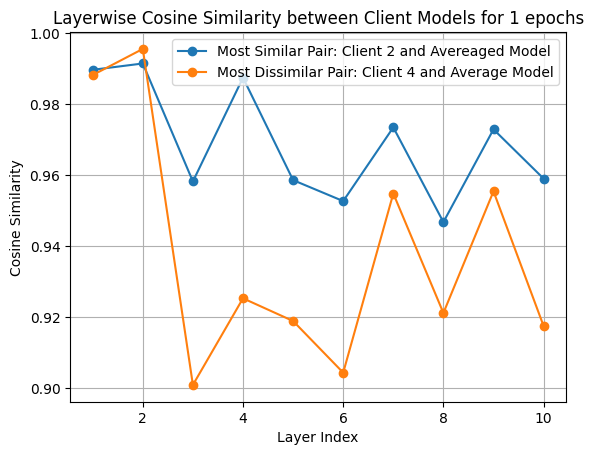

In [313]:
averaged_layer_similarities(one_epoch_average_model_list,five_epoch_average_model_list, 1)

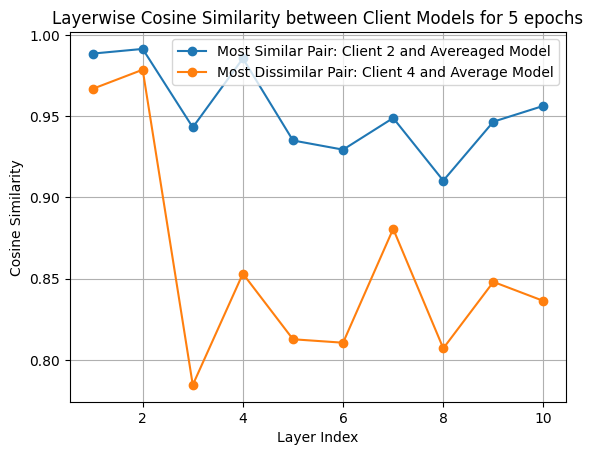

In [314]:
averaged_layer_similarities(five_epoch_average_model_list,five_epoch_average_model_list, 5)

Part 2:

**Written Answer:**

From the graph we can see that as the number of epoch was increased from 1 to 5 the similarity between the averaged model and its most similar model decreases minimally compared to its most dissimilar model not just regarding the single cosine similarity score but the layer wise similarity as well. The difference is again mainly visible in the deeper layers of the models where the models learn more specific features of the dataset.

---

The pieces necessary for starting an FL simulation are now in play; we need to arrange them to fit the Flower API. First, we shall require a separate federated evaluation function which can be called outside the context of a specific client. It will use the centralised test set to be as simple as possible.

In [346]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    -------
        Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
            external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["max_batches"],
)

In [347]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [348]:
# Federated configuration dictionary
federated_train_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

The only challenge left is the FL simulation itself. In `Flower`, a `Server` object handles this for us by using `Ray` and spawning many heavyweight worker process.

Given the limited-resource scenario in which we find ourselves, we provide you with a slightly modified simulation function which uses a simple thread pool. Feel free to swap it out for the original simulation or replace it with your own implementation if so inclined.

> The server we use is not the default `Flower` server as it returns the model parameters from every single round in a `(round, NDArrays)` tuple.

In [349]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

In [350]:
num_rounds = 60

num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)


def run_simulation(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

In [351]:
parameters_for_each_round, hist = run_simulation()

INFO flwr 2025-02-10 14:09:36,713 | 4290565425.py:56 | FL will execute for 60 rounds
INFO flwr 2025-02-10 14:09:36,717 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)
INFO flwr 2025-02-10 14:09:36,731 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-10 14:09:36,735 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-10 14:09:36,738 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:01<00:11, 67.93it/s]
INFO flwr 2025-02-10 14:09:38,263 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6842656135559, {'accuracy': 0.0065625}
INFO flwr 2025-02-10 14:09:38,263 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-10 14:09:38,264 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)
INFO flwr 2025-02-10 14:09:38,265 | 2290543087.py:21 

In [353]:
log(
    INFO,
    "Size of the list with the model parameters: %s",
    len(parameters_for_each_round),
)

INFO flwr 2025-02-10 14:11:53,660 | 1532827960.py:1 | Size of the list with the model parameters: 61


---

**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Now that an entire FL experiment can be trained, it is worth considering the relationship between the FL model across rounds. If we consider the final model $\theta^N$ obtained after $N$ rounds to be the optimal model $\theta^*$, we can ask how optimization step contributed to reaching $\theta^*$.

1. Run an FL simulation for at-least 50 rounds.
2. Build a function which reconstitutes the update that must have been applied to model $\theta^t$ in order to obtain $\theta^{t+1}$, assume the `server_learning_rate` was 1.0. We shall call this update $g_t$ and treat it as a pseudo-gradient.
3. For each round plot the cosine similarity between $g_t$ and the direction of improvement towards $\theta^{*}$ calculated as $\theta^{*} - \theta_t$.
4. What do you observe from the plots? Does every update point in the direction of the final model? If not, why do you think that is?

---



**Question 9 Answers:**


Part 1 and 2:

In [354]:



def get_network_updates(round_parameters:list)-> list:
    """
        Calculate the network updates for each round.

        Parameters
        ----------
            round_parameters (list): list of model parameters for each round.

        Returns
        -------
            list: list of network updates for each round.
    """
    network_updates = []
    for i in range(len(round_parameters)-1):
        network_update = round_parameters[i+1][1].copy()
        for j in range(len(round_parameters[i+1][1])):
            network_update[j] = np.subtract(round_parameters[i+1][1][j], round_parameters[i][1][j])
        network_updates.append(network_update)

    return network_updates


def get_direction_of_improvement(round_parameters:list)-> list:
    """
        Calculate the direction of improvement for each round.

        Parameters
        ----------
            round_parameters (list): list of model parameters for each round.

        Returns
        -------
            list: list of directions of improvement for each round.
    """

    direction_of_improvement = []
    final_model = round_parameters[-1][1]
    for i in range(len(round_parameters)-1):
        direction = final_model.copy()
        for j in range(len(direction)):
            direction[j] = np.subtract(final_model[j], round_parameters[i][1][j])
        direction_of_improvement.append(direction)
    
    return direction_of_improvement


def calculate_cosine_similarity_of_rounds(network_updates:list, direction_of_improvement:list)-> list:
    """
        Calculate the cosine similarity between the network updates and the direction of improvement for each round.

        Parameters
        ----------
            network_updates (list): list of network updates for each round.
            direction_of_improvement (list): list of directions of improvement for each round.

        Returns
        -------
            list: list of cosine similarities between the network updates and the direction of improvement for each round.
    """

    cosine_similarities = []
    for i in range(len(network_updates)):
        cosine_similarities.append(cosine_similarity(flatten_ndarray(network_updates[i]), flatten_ndarray(direction_of_improvement[i])))

    return cosine_similarities


def plot_cosine_similarities_of_rounds(cosine_similarities: list):
    """
        Plot the cosine similarity between the network updates and the direction of improvement for each round.

        Parameters
        ----------
            cosine_similarities (list): list of cosine similarities between the network updates and the direction of improvement for each round.
    """

    plt.plot(np.arange(1, len(cosine_similarities)+1), cosine_similarities, marker='o')
    plt.xlabel("Round")
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarity between Network Updates and Direction of Improvement")
    plt.grid(True)
    plt.show()


def get_cosine_similarities_of_rounds(round_parameters:list):
    """
        Calculate the cosine similarity between the network updates and the direction of improvement for each round and plot the results.

        Parameters
        ----------
            round_parameters (list): list of model parameters for each round.
    """
    
    network_updates = get_network_updates(round_parameters)
    direction_of_improvement = get_direction_of_improvement(round_parameters)
    cosine_similarities = calculate_cosine_similarity_of_rounds(network_updates, direction_of_improvement)
    plot_cosine_similarities_of_rounds(cosine_similarities)


Part 3:

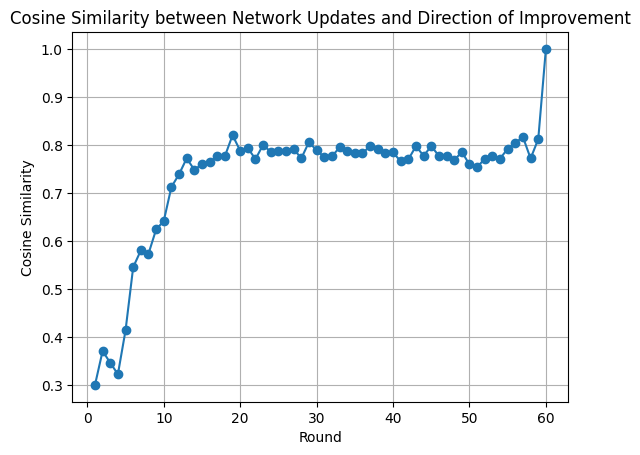

In [355]:
get_cosine_similarities_of_rounds(parameters_for_each_round)

Part 4:

**Written Answer:**


The graph shows low similarity between the model update and the direction of improvement in the early rounds which can be caused by the fact that the local models are still learning/know the features of their own dataset hence pushing the global model to different directions. As the number of rounds increases the similarity increases as well since the global model starts to learn more about the features of the entire dataset and the local models are also given the global models weights in each round thus decreasing the effect of their own datasets/over-fitting. However, this increase stops and the similarity plateaus and takes up an oscillatory behaviour around a relatively high value (mainly between 0.7 and 0.8 in this experiment) which can also be explained by the fact that, there is still inherent heterogeneity in the local data distributions. As training progresses, each client’s local updates -while more aligned with the global objective than in early rounds— continue to differ slightly because clients see different subsets of data. This oscillation remains until the last round where the similarity is 1, since it was the final round that contributed to the model it also has the remaining improvement equivalent to it.



---


---
**Question 10 (Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

and then for

1.   Read about server momentum in FL [here](https://arxiv.org/abs/2003.00295) and repeat the previous experiments using `server_learning_rate=1.0` and `server_momentum=0.9`. Discuss how the momentum impacts the direction of optimization.

---

**Question 10 Answers:**


In [360]:
momentum_parameters_for_each_round, momentunm_hist = run_simulation(server_momentum=0.9)

INFO flwr 2025-02-10 14:16:58,241 | 4290565425.py:56 | FL will execute for 60 rounds
INFO flwr 2025-02-10 14:16:58,244 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)
INFO flwr 2025-02-10 14:16:58,245 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-10 14:16:58,246 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-10 14:16:58,279 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:01<00:10, 76.48it/s]
INFO flwr 2025-02-10 14:16:59,636 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6842656135559, {'accuracy': 0.0065625}
INFO flwr 2025-02-10 14:16:59,637 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-10 14:16:59,637 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)
INFO flwr 2025-02-10 14:16:59,638 | 2290543087.py:21 

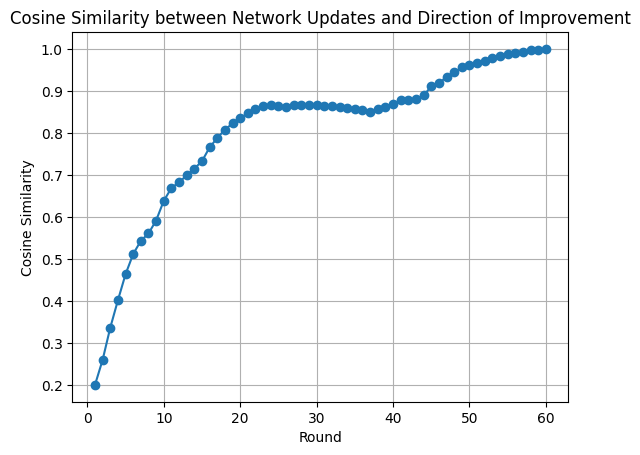

In [361]:
get_cosine_similarities_of_rounds(momentum_parameters_for_each_round)

**Written Answer:** Contrary to the previous experiment, this graph presents an increase in similarity throughout the rounds with minimal occasional oscillations/decrease. This continuous improvement in similarity can be explained by the use of server momentum, which accumulates previous update directions into a velocity vector proposed by [Hsu et al.](https://arxiv.org/pdf/1909.06335) . By incorporating a part of previously accumulated velocity vector (direction) with the server update, server momentum helps/aims minimizing oscillations/plateaus across rounds via decreasing the effect of the various directions of different client model updates due to their different local datasets hence directing the model update closer towards the direction of the final model. 

(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani